Aca vamos a hacer la parte de generacion y evaluacion de modelos

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,precision_score ,f1_score

from scripts import featurizer_xgb


In [2]:
df_trabajo = pd.read_csv("C:/Users/mlard/OneDrive/Escritorio/Mateo/Org de Datos/tp3Github/Org-Datos-Grupo-19/df_trabajo.csv", index_col=False)

In [3]:
# df.shape

In [4]:
# dff = featurizer_xgb.featurizer(df)

In [5]:
df_trabajo.shape

(276572, 109)

In [6]:
df_trabajo.columns

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'D_43', 'D_44',
       'B_4',
       ...
       'D_127', 'D_128', 'B_41', 'D_130', 'R_28', 'D_139', 'D_140', 'D_144',
       'D_145', 'target'],
      dtype='object', length=109)

In [7]:
#Separo en train y test para trabajar los modelos
df_trabajo_x=df_trabajo.drop(['target'], axis='columns', inplace=False)

df_trabajo_y = df_trabajo['target'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x, df_trabajo_y, test_size=0.3, random_state=1)

Modelo Random forest

Buscamos los mejores hiperparametros para el modelo Random forest

In [8]:
rf_cv = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5], 
               "max_features":["sqrt", "log2"],
               "min_samples_split" : [2, 5], 
               "n_estimators": [10,50] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1)

In [9]:
gs_fit = gs.fit(X = x_train, y = y_train)
best_params_rfc = gs_fit.best_params_

print(best_params_rfc)

{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}


Predecimos utilizando el mejor modelo q obtuvimos

In [10]:
rfc_best_model = RandomForestClassifier(**best_params_rfc)

In [11]:
model_rfc = rfc_best_model.fit(X = x_train,y = y_train)
y_pred_rfc = model_rfc.predict(x_test)
df_resultados_rfc=pd.DataFrame(zip(y_test,y_pred_rfc),columns=['test','predicted'])

In [12]:
#Para ver a presicion en el conjunto de datos de entrenamiento
y_train_rfc = model_rfc.predict(x_train)
# tabla=confusion_matrix(y_train, y_train_rfc)

# grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
# plt.show()

In [13]:
print("precision de entrenamiento : ", accuracy_score(y_train, y_train_rfc))
print("precicion de test : ", accuracy_score(df_resultados_rfc['test'], df_resultados_rfc['predicted']))
print('\n No hay overfitting')

precision de entrenamiento :  0.9707954545454546
precicion de test :  0.8683531793858169

 No hay overfitting


In [14]:
df_resultados_rfc.sample(5)

,test,predicted
64378,0.0,0.0
51588,1.0,0.0
78282,0.0,1.0
81345,0.0,0.0
12706,0.0,0.0


In [15]:
accuracy=accuracy_score(df_resultados_rfc['test'], df_resultados_rfc['predicted'], normalize=True)
print("Este modelo de Random forest tiene una accuracy del: " + str(round(accuracy, 5)) + "%")

Este modelo de Random forest tiene una accuracy del: 0.86835%


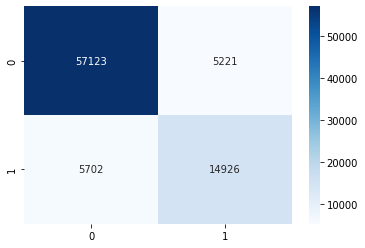

In [16]:
tabla=confusion_matrix(df_resultados_rfc['test'], df_resultados_rfc['predicted'])

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

In [17]:
def results_comparation(df_predict):
    df_predict["success"] = (df_predict["test"] == df_predict["predicted"])
    df_predict["success"].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title("Cantidad de valores predecidos correctamente") 
    plt.show()

    precicion = precision_score(df_predict['test'], df_predict['predicted'])
    f1=f1_score(df_predict['test'], df_predict['predicted'])
    recall = recall_score(df_predict['test'], df_predict['predicted'])
    
    print(f"Precision score: \t{round(precicion,3)}")
    print(f"Recall score: \t\t{round(recall,3)}")
    print(f"F1 score: \t\t{round(f1,3)}")

    accuracy=accuracy_score(df_predict['test'], df_predict['predicted'], normalize=True)
    print("Tiene una accuracy del: " + str(round(accuracy, 3)) + "% como muestra el pie chart")


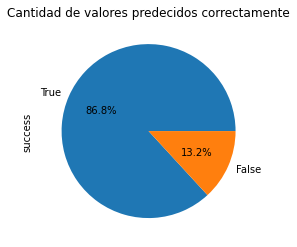

Precision score: 	0.741
Recall score: 		0.724
F1 score: 		0.732
Tiene una accuracy del: 0.868% como muestra el pie chart


In [18]:
results_comparation(df_resultados_rfc)

Modelo XGBoost

In [19]:
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier

In [20]:
# df_featurizado = featurizer_xgb.featurizer(df_trabajo)
df_featurizado = df_trabajo

In [21]:
X_xgb = df_featurizado.drop(axis = 1, columns = ['target'])
y_xgb = df_featurizado.target

features = X_xgb.columns

In [22]:
xgb = XGBClassifier()

In [23]:
#Set hyperparameters dictionary
param_dist = {'n_estimators':[50, 100],
              'max_depth':[5,10],              
              'subsample': [0.5,0.8,1],
              'colsample_bytree': [0.5,0.8,1],              
              'learning_rate':[0.01, 0.1, 0.3]
              }

In [24]:
random_search_xgb = RandomizedSearchCV(xgb,
                                       param_distributions = param_dist,
                                       n_iter = 2,
                                       scoring = 'roc_auc',
                                       cv = 5,
                                       n_jobs = -1,
                                       verbose=5)

In [25]:
%time
random_search_xgb.fit(x_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [5, 10],
                                        'n_estimators': [50, 100],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring='roc_auc', verbose=5)

In [26]:
params_opt_xgb = random_search_xgb.best_params_

In [27]:
params_opt_xgb

{'subsample': 0.5,
 'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.3,
 'colsample_bytree': 0.5}

In [28]:
xgbModelBestParams = XGBClassifier(**params_opt_xgb)

In [29]:
%time
model_xgb = xgbModelBestParams.fit(X = x_train,y = y_train)
y_pred_xgb = model_xgb.predict(x_test)
df_resultados_xgb=pd.DataFrame(zip(y_test,y_pred_xgb),columns=['test','predicted'])

CPU times: total: 0 ns
Wall time: 1 ms


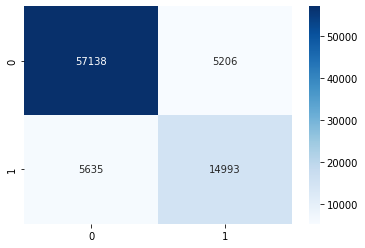

In [30]:
tabla=confusion_matrix(df_resultados_xgb['test'], df_resultados_xgb['predicted'])

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

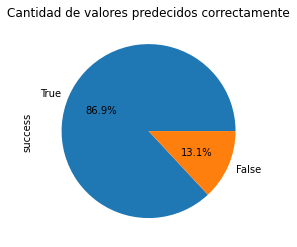

Precision score: 	0.742
Recall score: 		0.727
F1 score: 		0.734
Tiene una accuracy del: 0.869% como muestra el pie chart


In [31]:
results_comparation(df_resultados_xgb)

Suport Vector Machine

In [32]:
from sklearn.svm import SVC

Ensamble de modelos

In [33]:
from sklearn.ensemble import VotingClassifier

In [34]:
vot_clf = VotingClassifier(estimators = [('rnd', rfc_best_model),('xgb', xgbModelBestParams)], voting = 'hard')

In [35]:
vot_clf.fit(x_train, y_train)
pred_vot_clf = vot_clf.predict(x_test)

df_resultados_vot_clf=pd.DataFrame(zip(y_test,pred_vot_clf),columns=['test','predicted'])

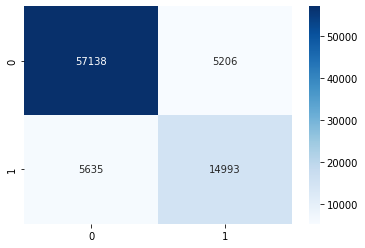

In [36]:
tabla=confusion_matrix(df_resultados_xgb['test'], df_resultados_xgb['predicted'])

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

Tabla de confusion de entrenamiento: 


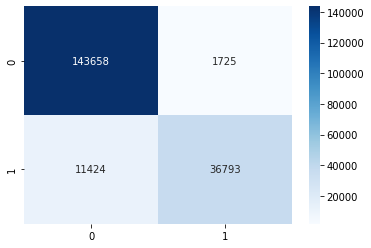

In [37]:
y_train_vot_clf = vot_clf.predict(x_train)
tabla=confusion_matrix(y_train, y_train_vot_clf)
print('Tabla de confusion de entrenamiento: ')
grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

In [40]:
print("precision de entrenamiento : ", accuracy_score(y_train, y_train_vot_clf))
print("precicion de test : ", accuracy_score(df_resultados_vot_clf['test'], df_resultados_vot_clf['predicted']))
print('\n')
print('Se puede ver que la precicion para el voting classifier no tiene overfitting ni underfitting')

precision de entrenamiento :  0.9320816115702479
precicion de test :  0.8674854167671021


Se puede ver que la precicion para el voting classifier no tiene overfitting ni underfitting


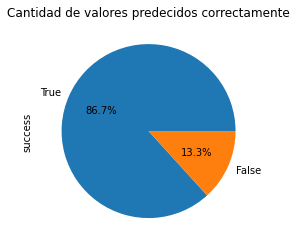

Precision score: 	0.773
Recall score: 		0.661
F1 score: 		0.713
Tiene una accuracy del: 0.867% como muestra el pie chart


In [39]:
results_comparation(df_resultados_vot_clf)